Import the required packages. For more information on SPICE kernels, read the original documentation or look at these great python packages: [Spiceypy](https://spiceypy.readthedocs.io/en/main/), [astrospice](https://astrospice.readthedocs.io/en/stable/), [HelioPy](https://docs.heliopy.org/en/stable/).

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time, TimeDelta
from astropy.visualization import quantity_support
from sunpy.coordinates import HeliographicCarrington
import astrospice

import helpers # some extra functions
cadence = 6 * u.hour

Load the Parker Solar Probe kernels.

In [2]:
psp_kernels = astrospice.registry.get_kernels('psp', 'predict')
psp_kernel = psp_kernels[0]
psp_coverage = psp_kernel.coverage('SOLAR PROBE PLUS')
print(psp_coverage.iso)

#now get the data required. To stop the html file being too large I will only get data every 6 hours.
dt = TimeDelta(cadence)
psp_times = Time(np.arange(psp_coverage[0], psp_coverage[1], dt))
coords = astrospice.generate_coords('SOLAR PROBE PLUS', psp_times)

#transform to Carrington frame, as it is a nice frame to compare spacecraft
carr_frame = HeliographicCarrington(observer='self')
psp_coords = coords.transform_to(carr_frame)

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.61file/s]


['2018-08-12 08:15:14.160' '2025-08-31 10:46:16.098']


Plot the results to check that they are correct. In this case you should see lots of loops are Parker Solar Probe goes through its perihelion and super-corotates with the Sun's surface.

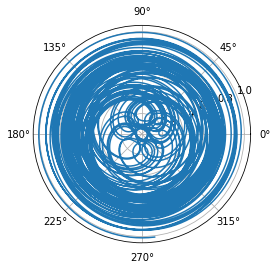

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.plot(psp_coords.lon.to(u.rad), psp_coords.radius.to(u.au))
plt.show()

Load the Solar Orbiter data

In [4]:
solo_kernels = astrospice.registry.get_kernels('solar orbiter', 'predict')
solo_kernel = solo_kernels[0]
solo_coverage = solo_kernel.coverage('SOLAR ORBITER')
print(solo_coverage.iso)

dt = TimeDelta(cadence)
solo_times = Time(np.arange(solo_coverage[0], solo_coverage[1], dt))
coords = astrospice.generate_coords('SOLAR ORBITER', solo_times)

solo_coords = coords.transform_to(carr_frame)

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  3.20file/s]


['2020-02-10 04:55:49.670' '2030-11-20 12:48:13.511']


In [5]:
sta_kernels = astrospice.registry.get_kernels('stereo-a', 'predict')
sta_kernel = sta_kernels[0]
# sta_coverage = sta_kernel.sta_coverage('STEREO Ahead')
# print(sta_coverage.iso)

#I will only get stereo-A data between PSP and Orbiter measurements
dt = TimeDelta(cadence)
sta_times = Time(np.arange(psp_coverage[0], solo_coverage[1], dt))
coords = astrospice.generate_coords('STEREO Ahead', sta_times)

sta_coords = coords.transform_to(carr_frame)

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.73file/s]


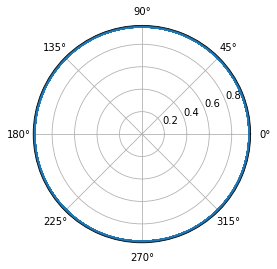

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.plot(sta_coords.lon.to(u.rad), sta_coords.radius.to(u.au))
plt.show()

Load the BepiColombo SPICE kernels. This is not yet implemented into astrospice so we will go for the metakernel method.astrospice
1. Download the [zip](https://www.cosmos.esa.int/web/spice/spice-for-bepicolombo) file from ESA
2. Edit the `bc_plan.tm` metakernel so that it points to the right folder

i.e. `PATH_VALUES       = ( '..' )` is now `PATH_VALUES       = ( 'PATH_TO_YOUR_FOLDER' )`

3. Now just furnish the metakernel, which will then furnish all the files it specifies

In [7]:
import spiceypy

bepi_kernel = astrospice.kernel.KernelBase("./bepi_kernels/mk/bc_plan.tm")
#this is not supported in astrospice yet, but we can use the same coverage
#I had to just keep trying the different spk files until one worked
coverage = [t for t in spiceypy.spkcov("./bepi_kernels/spk/bc_mpo_fcp_00116_20181020_20251101_v01.bsp", spiceypy.bodn2c("BEPICOLOMBO MPO"))]
bepi_coverage = Time(coverage, format='et').utc
print(bepi_coverage.iso)

dt = TimeDelta(cadence)
bc_times = Time(np.arange(bepi_coverage[0], bepi_coverage[1], dt))
coords = astrospice.generate_coords('BEPICOLOMBO MPO', bc_times)

bc_coords = coords.transform_to(carr_frame)


['2018-10-20 02:12:19.537' '2025-11-01 22:59:45.944']


Load Earth trajectory, which we will use as a proxy for Wind, ACE and DSCOVR.

In [8]:
dt = TimeDelta(cadence)
earth_times = Time(np.arange(psp_coverage[0], solo_coverage[1], dt))
coords = astrospice.generate_coords('EARTH', earth_times)

earth_coords = coords.transform_to(carr_frame)

Plot in matplotlib just to see if it looks right. PSP (red) gets closer and closer, and Solar Orbiter (purple) goes higher in latitude as expected.

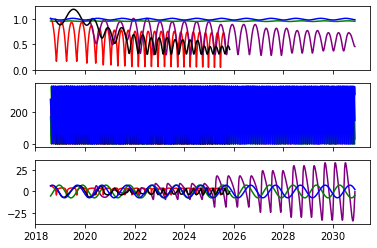

In [9]:
fig, axs = plt.subplots(3,1, sharex = True)

axs[0].plot(psp_times.datetime64, psp_coords.radius.to(u.au), color = 'red')
axs[0].plot(solo_times.datetime64, solo_coords.radius.to(u.au), color = 'purple')
axs[0].plot(sta_times.datetime64, sta_coords.radius.to(u.au), color = 'green')
axs[0].plot(bc_times.datetime64, bc_coords.radius.to(u.au), color = 'black')
axs[0].plot(earth_times.datetime64, earth_coords.radius.to(u.au),color = 'blue')

axs[1].plot(psp_times.datetime64, psp_coords.lon.degree, color = 'red')
axs[1].plot(solo_times.datetime64, solo_coords.lon.degree, color = 'purple')
axs[1].plot(sta_times.datetime64, sta_coords.lon.degree, color = 'green')
axs[1].plot(bc_times.datetime64, bc_coords.lon.degree, color = 'black')
axs[1].plot(earth_times.datetime64, earth_coords.lon.degree,color = 'blue')

axs[2].plot(psp_times.datetime64, psp_coords.lat.degree, color = 'red')
axs[2].plot(solo_times.datetime64, solo_coords.lat.degree, color = 'purple')
axs[2].plot(sta_times.datetime64, sta_coords.lat.degree, color = 'green')
axs[2].plot(bc_times.datetime64, bc_coords.lat.degree, color = 'black')
axs[2].plot(earth_times.datetime64, earth_coords.lat.degree,color = 'blue')

To compare the spacecraft at the Sun it is useful to Ballistically map them back to the surface.

In [34]:
import astropy.constants as const
import pandas as pd

rss = 2.5*const.R_sun

psp_df = pd.DataFrame({'Radius': psp_coords.radius.value, 
                        'Carr_lon': psp_coords.lon.value,
                        'Carr_lat': psp_coords.lat.value}, index = psp_times.datetime64)

psp_df['Mapped_300'] = helpers.ballistic_map(psp_coords, rss, 300*u.km/u.s)
psp_df['Mapped_700'] = helpers.ballistic_map(psp_coords, rss, 700*u.km/u.s)

solo_df = pd.DataFrame({'Radius': solo_coords.radius.value, 
                        'Carr_lon': solo_coords.lon.value,
                        'Carr_lat': solo_coords.lat.value}, index = solo_times.datetime64)
solo_df['Mapped_300'] = helpers.ballistic_map(solo_coords, rss, 300*u.km/u.s)
solo_df['Mapped_700'] = helpers.ballistic_map(solo_coords, rss, 700*u.km/u.s)

sta_df = pd.DataFrame({'Radius': sta_coords.radius.value, 
                        'Carr_lon': sta_coords.lon.value,
                        'Carr_lat': sta_coords.lat.value}, index = sta_times.datetime64)
sta_df['Mapped_300'] = helpers.ballistic_map(sta_coords, rss, 300*u.km/u.s)
sta_df['Mapped_700'] = helpers.ballistic_map(sta_coords, rss, 700*u.km/u.s)

bc_df = pd.DataFrame({'Radius': bc_coords.radius.value, 
                        'Carr_lon': bc_coords.lon.value,
                        'Carr_lat': bc_coords.lat.value}, index = bc_times.datetime64)
bc_df['Mapped_300'] = helpers.ballistic_map(bc_coords, rss, 300*u.km/u.s)
bc_df['Mapped_700'] = helpers.ballistic_map(bc_coords, rss, 700*u.km/u.s)

earth_df = pd.DataFrame({'Radius': earth_coords.radius.value, 
                        'Carr_lon': earth_coords.lon.value,
                        'Carr_lat': earth_coords.lat.value}, index = earth_times.datetime64)
earth_df['Mapped_300'] = helpers.ballistic_map(earth_coords, rss, 300*u.km/u.s)
earth_df['Mapped_700'] = helpers.ballistic_map(earth_coords, rss, 700*u.km/u.s)

In [41]:
# =============================================================================
# Make an interactive version of the time series
# =============================================================================
from plotly.subplots import make_subplots
import plotly.express as px

from plotly.subplots import make_subplots

from datetime import datetime


fig = make_subplots(rows=4, cols=1,shared_xaxes=True )

#this might take a long time to run
fig = helpers.add_sc(fig, psp_df, 'PSP', 'red')
fig = helpers.add_sc(fig, solo_df, 'Solar Orbiter', 'purple')
fig = helpers.add_sc(fig, bc_df, 'BepiColombo', 'black')
fig = helpers.add_sc(fig, earth_df, 'Earth', 'blue')
fig = helpers.add_sc(fig, sta_df, 'STEREO-A', 'green')
#add hover info of the source longitude and latitude

fig.update_layout(title_text="Interactive Orbits",
                  hovermode="x")


fig.update_xaxes(rangeselector=dict(buttons=list([
                    dict(count=1, label="Year", step="year", stepmode="backward"),
                    dict(count=1, label="Month", step="month", stepmode="backward"),
                    dict(count=7, label="Week", step="day", stepmode="backward"),
                    dict(step="all")])))

fig.update_yaxes(title_text="Radius", row=1, col=1)
fig.update_yaxes(title_text="Latitude", row=2, col=1)
fig.update_yaxes(title_text="Longitude", range=[0, 360],tick0 = 0,
        dtick = 90, row=3, col=1)
fig.update_yaxes(title_text="Mapped Longitude", range=[0, 360],tick0 = 0,
        dtick = 90, row=4, col=1)

fig.update_xaxes( range=[psp_coverage[0].datetime, solo_coverage[1].datetime], row=4, col=1)

fig.write_html('interactive_orbits.html', auto_open=True)